## 学校の Class 編成

## Data の確認
最初に、手もとの Data を確認していく。
集計や統計値を確認することで Data の特性を理解し、どのような学年なのかつかむことが実務のこつ。

In [1]:
# 生徒 Data の読み込み
import pandas as pd

s_df = pd.read_csv('students.csv')

In [2]:
# 行数の確認
s_df.shape[0]

318

生徒の数だと想像される。

In [3]:
# どのような Data か確認する
s_df.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


生徒 Data の概要

| Column       | 説明                          |
|--------------|-----------------------------|
| student_id   | 1 ~ 318 で unique な整数値をとる    |
| gender       | 0: 女性, 1: 男性                |
| leader_flag  | 1: Leader 気質の生徒, 0: それ以外の生徒 |
| support_flag | 1: 特別な支援が必要な生徒, 2: それ以外の生徒  |
| score        | 0点 ~ 500点の間の整数値をとる          |

In [4]:
# student_id の Data を確認
from IPython.display import display

display(s_df['student_id'])

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [5]:
# student_id の最大値を確認
s_df['student_id'].max()

318

In [6]:
# student_id の最小値を確認
s_df['student_id'].min()

1

In [7]:
# 1 ~ 318 までの番号が使用されていることを確認
set(range(1, 319)) == set(s_df['student_id'].tolist())

True

In [8]:
# gender の Data を確認
s_df['gender'].value_counts()

0    160
1    158
Name: gender, dtype: int64

女性: 160名, 男性: 158名と確認できる

In [9]:
# score data の統計値を確認
s_df['score'].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<AxesSubplot:>

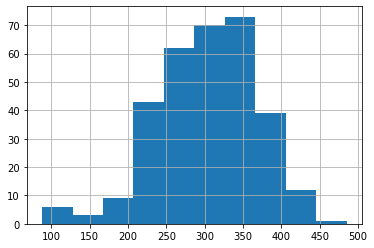

In [10]:
# 学力の分布 Histogram を確認する
s_df['score'].hist()

In [11]:
# Leader 気質の生徒数の確認
s_df['leader_flag'].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [12]:
# 特別な支援が必要な生徒数の確認
s_df['support_flag'].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

In [13]:
# 特定 Pair（student_pairs.csv） の確認
s_pair_df = pd.read_csv('student_pairs.csv')  # 特定 Pair data を読み込み
print(s_pair_df.shape[0])  # Data 行数を表示

3


In [14]:
# Data の詳細を確認
s_pair_df.head()

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


## 数理 Modeling と実装

In [15]:
import pulp

In [16]:
# 数理 Model の Instance 作成
prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

### 要件1). 学年の全生徒をそれぞれ１つの Class に割り当てる

In [17]:
# 生徒の List
S = s_df['student_id'].tolist()

In [18]:
# Class の List
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [19]:
# 生徒と Class の Pair の List
SC = [(s, c) for s in S for c in C]

# 生徒をどの Class に割り当てるかを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

In [20]:
# 1). 各生徒は１つの Class に割り当てる
for s in S:
    prob += pulp.lpSum(x[s, c] for c in C) == 1

### 2). 各 Class の生徒の人数は 39人以上、40人以下とする

In [21]:
# 2). 各 Class の生徒の人数は 39人以上、40人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <=40

### 3). 各 Class の男子生徒、女子生徒の人数を20人以下とする

In [22]:
# 男子生徒の List
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒の List
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

# 3). 各 Class の男子生徒、女子生徒の人数は 20人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

### 4). 各Class の学力試験の平均点は学年平均点±10点とする

In [23]:
# 学力を辞書表現に変換
score = {row.student_id: row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()

# (4) 各 Class の学力試験の平均点は学年平均点±10点とする
for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) <= pulp.lpSum(x[s, c] * score[s] for s in S)
    prob += pulp.lpSum([x[s, c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

### 5).各 Class に Leader 気質の生徒を２人以上割り当てる

In [24]:
# Leader 気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5)各 Class に Leader 気質の生徒を２人以上割り当てる
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

### 6). 特別な支援が必要な生徒は各 Class に１人以下とする

In [25]:
# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

# (6)特別な支援が必要な生徒は各 Class に１人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

### 7). 特定 Pair の生徒は同一 Class に割り当てない

In [26]:
# 生徒の特定 Pair list
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

# (7)特定 Pair の生徒は同一　Class に割り当てない
for s1, s2 in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1

In [27]:
# 求解
status = prob.solve()
print(status)
print(pulp.LpStatus[status])

1
Optimal


In [28]:
# 最適化結果の表示
# 各 Class に割り当てられている生徒の list を dict に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]


for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Class: A
Num: 39
Student: [9, 10, 25, 26, 34, 35, 47, 56, 73, 75, 98, 102, 103, 106, 108, 114, 118, 122, 123, 126, 139, 143, 156, 176, 199, 201, 216, 235, 248, 257, 270, 278, 280, 284, 288, 294, 297, 301, 314]

Class: B
Num: 40
Student: [4, 11, 17, 29, 44, 50, 89, 100, 110, 111, 117, 120, 127, 132, 135, 144, 147, 150, 157, 188, 189, 190, 212, 218, 230, 238, 239, 241, 245, 252, 262, 269, 271, 274, 281, 282, 287, 302, 306, 309]

Class: C
Num: 40
Student: [14, 31, 36, 37, 54, 58, 59, 61, 69, 72, 77, 78, 81, 86, 112, 119, 133, 142, 160, 161, 171, 186, 187, 192, 205, 209, 213, 217, 229, 236, 253, 256, 266, 273, 290, 295, 304, 310, 312, 318]

Class: D
Num: 40
Student: [2, 16, 21, 33, 38, 63, 68, 71, 85, 97, 109, 134, 140, 146, 158, 159, 168, 177, 180, 194, 198, 210, 220, 221, 225, 231, 240, 242, 246, 254, 268, 275, 277, 279, 283, 286, 292, 293, 311, 317]

Class: E
Num: 40
Student: [5, 6, 20, 22, 24, 28, 30, 32, 42, 53, 60, 70, 79, 92, 94, 105, 128, 129, 131, 154, 169, 173, 175, 178, 181, 182

## 数理 Model の検証

### 解が要件を満たしているかどうかを確認する

#### 要件(1)学年の全生徒をそれぞれ１つの Class に割り当てる

In [29]:
# 検証: 生徒が複数の Class に割り当てられていないか確認する。
for s in S:
    # 割り当てられた Class を取得
    assigned_class = [x[s, c].value() for c in C if x[s, c].value() == 1]

    # １つの Class に割り当てられているか確認
    if len(assigned_class) != 1:
        print('error:', s, assigned_class)

error が表示されないため、生徒が複数の Class に割り当てられていないことを確認。

以降の検証をしやすくする為、各生徒がどの Class に割り当てられているか、の情報を生徒 Data に格納していく。

In [30]:
# 検証用の DataFrame の用意
result_df = s_df.copy()  # s_df.copy() で入力 Data を変更せずにそのまま残しておくことで、後々不具合が入った場合など調査しやすい。

# 各生徒がどの Class に割り当てられたかの情報を辞書に格納
S2C = {s: c for s in S for c in C if x[s, c].value() == 1}

# 生徒 Data に各生徒がどの Class に割り当てられたかの情報を結合
result_df['assigned_class'] = result_df['student_id'].map(S2C)
result_df.head()

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,G
1,2,1,0,0,379,D
2,3,0,0,0,350,F
3,4,0,0,0,301,B
4,5,1,0,0,317,E


#### 要件(2) 各 Class の生徒の人数は 39人以上、40人以下とする

In [31]:
# 検証: assigned_class 毎の student_id の数を確認する
result_df.groupby('assigned_class')['student_id'].count()

# 別の書き方:
# result_df.groupby('assigned_class').count()['student_id']

assigned_class
A    39
B    40
C    40
D    40
E    40
F    39
G    40
H    40
Name: student_id, dtype: int64

39, 40人であることが確認とれた。

#### 各 Class の男子生徒、女子生徒の人数は 20人以下とする

In [32]:
# 検証: 各 Class 毎の男女の student_id の数を確認する
result_df.groupby(['assigned_class', 'gender'])['student_id'].count()

# 別の書き方:
# result_df.groupby(['assigned_class', 'gender']).count()['student_id']

assigned_class  gender
A               0         20
                1         19
B               0         20
                1         20
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         19
G               0         20
                1         20
H               0         20
                1         20
Name: student_id, dtype: int64

各 Class の男女の人数が 20人、または 19人で、Balance がとれていることを確認。

#### 要件(4) 各 Class の学力試験の平均点は学年平均点 ±10点とする

In [33]:
# 検証: 平均点303.6点と各 Class の平均点を比較する
result_df.groupby('assigned_class')['score'].mean()

# 別の書き方
# result_df.groupby('assigned_class').mean()['score']

check_s = result_df.groupby('assigned_class')['score'].mean()
check_df = pd.DataFrame(check_s)
check_df['diff'] = check_df['score'] - 303.6
check_df

,score,diff
assigned_class,,
A,312.333333,8.733333
B,295.475000,-8.125000
C,293.650000,-9.950000
D,313.600000,10.000000
E,312.950000,9.350000
F,294.538462,-9.061538
G,312.550000,8.950000
H,294.050000,-9.550000


各 Class の平均点が全体の平均点303.6点の ±10点以内に収まっていて、大きな偏りがないことが確認できる。

#### 要件(5) 各 Class に Leader 気質の生徒を２人以上割り当てる

In [34]:
# 検証: 各 Class の Leader_flag の合計数を確認する
result_df.groupby(['assigned_class'])['leader_flag'].sum()

# 別の書き方
# result_df.groupby(['assigned_class']).sum()['leader_flag']

assigned_class
A    2
B    2
C    2
D    2
E    2
F    2
G    3
H    2
Name: leader_flag, dtype: int64

各 Class に２人以上、Leader気質の生徒が割り当てられていることを確認

#### 要件(6) 特別な支援が必要な生徒は各 Class に1人以下とする

In [35]:
# 検証: 各 Class の support_flag の合計数を確認する
result_df.groupby('assigned_class')['support_flag'].sum()

# 別の書き方
# result_df.groupby('assigned_class').sum()['support_flag']

assigned_class
A    1
B    0
C    1
D    0
E    0
F    1
G    1
H    0
Name: support_flag, dtype: int64

特別な支援が必要な生徒が 各 Class に１名以下であることを確認

#### 要件(7) 特定 Pair の生徒は同一 Class に割り当てない

In [36]:
# 検証: それぞれの特定 Pair の　student_id と Class の組み合わせを表示して別の Class に割り当てられているか確認する
for i, (s1, s2) in enumerate(SS):  # enumerate() を使用して Index も取得する
    print('case:', i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print(f"s1: {s1}-{c1}")
    print(f"s2: {s2}-{c2}")
    print('')

case: 0
s1: 118-A
s2: 189-B

case: 1
s1: 72-C
s2: 50-B

case: 2
s1: 314-A
s2: 233-E



３組の特定 Pair が Class が被っていないことを確認。